In [1]:
from idiva.db.ncbi_scraper import get_functional_consequence_from_SNP
from pathlib import Path
from idiva.io import ReadVCF
import os
import pandas as pd

BASE = (Path(os.path.abspath("database_exploration.ipynb")).parent.parent.parent) / "tests/data_for_tests/large_head"

PATHS = {
    'ctrl': BASE / "control.vcf",
    'case': BASE / "case_processed.vcf",
}

In [2]:
functional_consequence_set = {'non_coding_transcript_variant,intron_variant,genic_downstream_transcript_variant'}

functional_consequence_df = pd.DataFrame()

In [63]:
with open(PATHS['ctrl'], mode='r') as fd:
    for elem in ReadVCF(fd):
        info = get_functional_consequence_from_SNP(elem.id)
        functional_consequence_set.add(info)
        functional_consequence_df = functional_consequence_df.append({'rs_ID':elem.id,'functional_consequence': info}, ignore_index=True)

/Users/Hendrik/Documents/master3/Computaitonal_Biomedicine/Team03/project2/solution/idiva/db/ncbi_scraper.py:47: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 47 of the file /Users/Hendrik/Documents/master3/Computaitonal_Biomedicine/Team03/project2/solution/idiva/db/ncbi_scraper.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(page.content)


In [4]:
with open(PATHS['case'], mode='r') as fd:
    for elem in ReadVCF(fd):
        info = get_functional_consequence_from_SNP(elem.id)
        functional_consequence_set.add(info)
        functional_consequence_df = functional_consequence_df.append({'rs_ID':elem.id,'functional_consequence': info}, ignore_index=True)

In [5]:
functional_consequence_df

,functional_consequence,rs_ID
0,"genic_downstream_transcript_variant,intron_var...",rs556541063
1,"genic_downstream_transcript_variant,intron_var...",rs145615430
2,"intron_variant,genic_downstream_transcript_var...",rs148170422
3,"intron_variant,genic_downstream_transcript_var...",rs183779916
4,"genic_downstream_transcript_variant,intron_var...",rs562410061
...,...,...
195,"non_coding_transcript_variant,intron_variant,g...",rs532922553
196,"intron_variant,non_coding_transcript_variant,g...",rs80215721
197,"intron_variant,non_coding_transcript_variant,g...",rs191439637
198,"intron_variant,non_coding_transcript_variant,g...",rs149757548


In [6]:
print(functional_consequence_set)

{'intron_variant,non_coding_transcript_variant,genic_downstream_transcript_variant\n', 'non_coding_transcript_variant,intron_variant,genic_downstream_transcript_variant\n', 'intron_variant,genic_downstream_transcript_variant\n', 'genic_downstream_transcript_variant,downstream_transcript_variant,intron_variant\n', 'genic_downstream_transcript_variant,intron_variant,downstream_transcript_variant\n', 'downstream_transcript_variant,intron_variant,genic_downstream_transcript_variant\n', 'G=0.0006/3\n(1000Genomes)', 'genic_downstream_transcript_variant,intron_variant\n', 'intron_variant,downstream_transcript_variant,genic_downstream_transcript_variant\n', 'genic_downstream_transcript_variant,intron_variant,non_coding_transcript_variant\n', 'non_coding_transcript_variant,intron_variant,genic_downstream_transcript_variant'}


In [4]:
import findspark

findspark.init()



In [5]:
from pyspark import SparkContext
sc = SparkContext("local", "MySparkApp")

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Reading clinvar file into spark

In [7]:
clinvar_csv_gzip_path = Path(os.path.abspath("database_exploration.ipynb")).parent.parent.parent/ 'data/clinvar.gzip'
clinvar_csv_path = Path(os.path.abspath("database_exploration.ipynb")).parent.parent.parent/ 'data/clinvar.csv'

In [8]:
if not clinvar_csv_path.is_file():
    from idiva.db import clinvar_open
    from idiva.io import ReadVCF
    from idiva.db.clinvar import clinvar_to_df
    with clinvar_open(which='vcf_37') as fd:
        pdf_clinvar = clinvar_to_df(ReadVCF(fd))
    pdf_clinvar.to_csv(clinvar_csv_path, index = False)
else:
    pdf_clinvar = pd.read_csv(clinvar_csv_path)


/Users/Hendrik/opt/anaconda3/envs/cbm_project1_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_clinvar=spark.read.options(header='true').csv(str(clinvar_csv_path))

In [10]:
df_clinvar.show(10)

+-----+------+------+---+---+----+------+------+-------+--------+---------------+------------+--------------------+--------------------+--------------------+--------------------+----------+-------------+--------------------+------+-------+-------+-------+----------+-----+----------+------------+---------+----------+-------+
|chrom|   pos|    id|ref|alt|qual|filter|format|samples|ALLELEID|       CLNDISDB|       CLNDN|             CLNHGVS|          CLNREVSTAT|              CLNSIG|               CLNVC|   CLNVCSO|     GENEINFO|                  MC|ORIGIN| AF_ESP|AF_EXAC| AF_TGP|        RS|CLNVI|CLNSIGCONF|CLNDISDBINCL|CLNDNINCL|CLNSIGINCL|DBVARID|
+-----+------+------+---+---+----+------+------+-------+--------+---------------+------------+--------------------+--------------------+--------------------+--------------------+----------+-------------+--------------------+------+-------+-------+-------+----------+-----+----------+------------+---------+----------+-------+
|    1|865568|846933| 

# Reading clf files "ctrl" and "case" into spark

In [11]:
from pathlib import Path

from tcga.utils import download
download_cache = (Path(os.path.abspath("database_exploration.ipynb")).parent.parent.parent.parent / "input/download_cache")
print(download_cache)
assert download_cache.is_dir()

/Users/Hendrik/Documents/master3/Computaitonal_Biomedicine/Team03/project2/input/download_cache


In [12]:
download = download.to(abs_path=download_cache)

URLS = {
    'ctrl': "https://public.bmi.inf.ethz.ch/eth_intern/teaching/cbm_2020/cbm_2020_project2/control.vcf",
    'case': "https://public.bmi.inf.ethz.ch/eth_intern/teaching/cbm_2020/cbm_2020_project2/case_processed.vcf",
}
case_control_csv_path = Path(os.path.abspath("database_exploration.ipynb")).parent.parent.parent.parent / "input/head/case_control.csv"

In [13]:
if case_control_csv_path.is_file():
    pdf_case_control = pd.read_csv(case_control_csv_path)
else:
    from idiva.io import ReadVCF
    from idiva.clf.df import v0_df, join
    dfs = {}

    for k in URLS:
        with download(URLS[k]).now.open() as fd:
            dfs[k] = v0_df(ReadVCF(fd))

    pdf_case_control = join(case=dfs['case'], ctrl=dfs['ctrl'])
    pdf_case_control.to_csv(case_control_csv_path,index = False)


In [14]:
pdf_case_control.head()

,CHROM,POS,ID,ALT0_case,ALT1_case,ALT2_case,ALT0_ctrl,ALT1_ctrl,ALT2_ctrl
0,17,52,rs556541063,314.0,0.0,0.0,500.0,0.0,0.0
1,17,56,rs145615430,314.0,0.0,0.0,498.0,2.0,0.0
2,17,78,rs148170422,311.0,3.0,0.0,499.0,1.0,0.0
3,17,80,rs183779916,313.0,1.0,0.0,497.0,3.0,0.0
4,17,92,rs562410061,314.0,0.0,0.0,500.0,0.0,0.0


In [15]:
df_case_control=spark.read.options(header='true').csv(str(case_control_csv_path))

In [16]:
df_case_control.show(10)

+-----+---+-----------+---------+---------+---------+---------+---------+---------+
|CHROM|POS|         ID|ALT0_case|ALT1_case|ALT2_case|ALT0_ctrl|ALT1_ctrl|ALT2_ctrl|
+-----+---+-----------+---------+---------+---------+---------+---------+---------+
|   17| 52|rs556541063|    314.0|      0.0|      0.0|    500.0|      0.0|      0.0|
|   17| 56|rs145615430|    314.0|      0.0|      0.0|    498.0|      2.0|      0.0|
|   17| 78|rs148170422|    311.0|      3.0|      0.0|    499.0|      1.0|      0.0|
|   17| 80|rs183779916|    313.0|      1.0|      0.0|    497.0|      3.0|      0.0|
|   17| 92|rs562410061|    314.0|      0.0|      0.0|    500.0|      0.0|      0.0|
|   17|168|rs529798787|    314.0|      0.0|      0.0|    499.0|      1.0|      0.0|
|   17|173|rs536031036|    314.0|      0.0|      0.0|    500.0|      0.0|      0.0|
|   17|174|rs188505217|    314.0|      0.0|      0.0|    500.0|      0.0|      0.0|
|   17|185|rs528728697|    313.0|      1.0|      0.0|    500.0|      0.0|   

In [17]:
df_case_control.registerTempTable('case_control')
df_clinvar.registerTempTable('clinvar')



In [18]:
temp = spark.sql("select * from case_control, clinvar where clinvar.RS = case_control.ID")

In [19]:
temp.show(10)

+-----+--------+-----------+---------+---------+---------+---------+---------+---------+-----+--------+------+---+---+----+------+------+-------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------+--------------------+------+-------+-------+-------+-----------+--------------------+--------------------+------------+---------+----------+-------+
|CHROM|     POS|         ID|ALT0_case|ALT1_case|ALT2_case|ALT0_ctrl|ALT1_ctrl|ALT2_ctrl|chrom|     pos|    id|ref|alt|qual|filter|format|samples|ALLELEID|            CLNDISDB|               CLNDN|             CLNHGVS|          CLNREVSTAT|              CLNSIG|               CLNVC|   CLNVCSO|      GENEINFO|                  MC|ORIGIN| AF_ESP|AF_EXAC| AF_TGP|         RS|               CLNVI|          CLNSIGCONF|CLNDISDBINCL|CLNDNINCL|CLNSIGINCL|DBVARID|
+-----+--------+-----------+---------+---------+---------+---------+---------+---------+--

# With pandas
### pandas merge nans with nan, not sure how to cope with that.

In [20]:
pdf_clinvar.head()

,chrom,pos,id,ref,alt,qual,filter,format,samples,ALLELEID,...,AF_ESP,AF_EXAC,AF_TGP,RS,CLNVI,CLNSIGCONF,CLNDISDBINCL,CLNDNINCL,CLNSIGINCL,DBVARID
0,1,865568,846933,G,A,NaN,.,NaN,NaN,824438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,865583,972363,C,T,NaN,.,NaN,NaN,959431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,865628,789256,G,A,NaN,.,NaN,NaN,707587,...,0.00347,0.00622,0.0028,rs41285790,NaN,NaN,NaN,NaN,NaN,NaN
3,1,865655,969662,T,G,NaN,.,NaN,NaN,959432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,865716,843786,G,A,NaN,.,NaN,NaN,824439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
merge_on_RS = pdf_case_control.merge(pdf_clinvar[~pdf_clinvar.RS.isna()], left_on='ID', right_on='RS', how='inner')

In [36]:
merge_on_RS.head()

,CHROM,POS,ID,ALT0_case,ALT1_case,ALT2_case,ALT0_ctrl,ALT1_ctrl,ALT2_ctrl,chrom,...,AF_ESP,AF_EXAC,AF_TGP,RS,CLNVI,CLNSIGCONF,CLNDISDBINCL,CLNDNINCL,CLNSIGINCL,DBVARID
0,17,422471,rs573812629,314.0,0.0,0.0,498.0,2.0,0.0,17,...,NaN,0.00156,0.00080,rs573812629,NaN,NaN,NaN,NaN,NaN,NaN
1,17,423051,rs2034088,27.0,120.0,167.0,59.0,170.0,271.0,17,...,0.62068,NaN,0.72664,rs2034088,NaN,NaN,NaN,NaN,NaN,NaN
2,17,423056,rs537324339,314.0,0.0,0.0,500.0,0.0,0.0,17,...,NaN,0.00014,0.00020,rs537324339,NaN,NaN,NaN,NaN,NaN,NaN
3,17,424880,rs16953156,303.0,11.0,0.0,488.0,12.0,0.0,17,...,0.02300,NaN,0.01198,rs16953156,NaN,NaN,NaN,NaN,NaN,NaN
4,17,424934,rs59240016,308.0,4.0,2.0,491.0,9.0,0.0,17,...,0.01029,0.00399,0.00879,rs59240016,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
merge_on_RS['ID'].isna().sum()

0

In [39]:
len(merge_on_RS)

10777

In [38]:
merge_on_RS.loc[((temp['CLNSIG'] == 'not_provided') | (merge_on_RS['CLNSIG'] == 'Uncertain_significance')), 'CLNSIG'].count()

1615

In [34]:
pdf_clinvar['ALLELEID'].isna().sum()

0

In [24]:
pdf_case_control['ID'].isna().sum()

4

# Merging on CHROM and POS
## In total, 12638 of the 2361508 variants in the case-control vcf match with the clinvar vcf. 2636 of those are meaningless

In [25]:
new_df = pd.merge(pdf_case_control.astype({'CHROM':str, 'POS':str}), pdf_clinvar.astype({'chrom':str, 'pos':str}), how='inner', left_on=['CHROM', 'POS'], right_on=['chrom', 'pos'])

In [26]:
len(pdf_case_control)

2361508

In [27]:
len(new_df)


12638

In [28]:
set(new_df['CLNSIG'])

{'Affects',
 'Benign',
 'Benign,_other',
 'Benign/Likely_benign',
 'Benign/Likely_benign,_other',
 'Conflicting_interpretations_of_pathogenicity',
 'Conflicting_interpretations_of_pathogenicity,_risk_factor',
 'Likely_benign',
 'Likely_pathogenic',
 'Pathogenic',
 'Pathogenic,_risk_factor',
 'Pathogenic/Likely_pathogenic',
 'Pathogenic/Likely_pathogenic,_risk_factor',
 'Uncertain_significance',
 'association',
 'drug_response',
 nan,
 'not_provided',
 'protective',
 'risk_factor'}

In [29]:
new_df['CLNSIG'].isna().sum()


2

In [30]:
new_df.loc[((new_df['CLNSIG'] == 'not_provided') | (new_df['CLNSIG'] == 'Uncertain_significance')), 'CLNSIG'].count()



2636

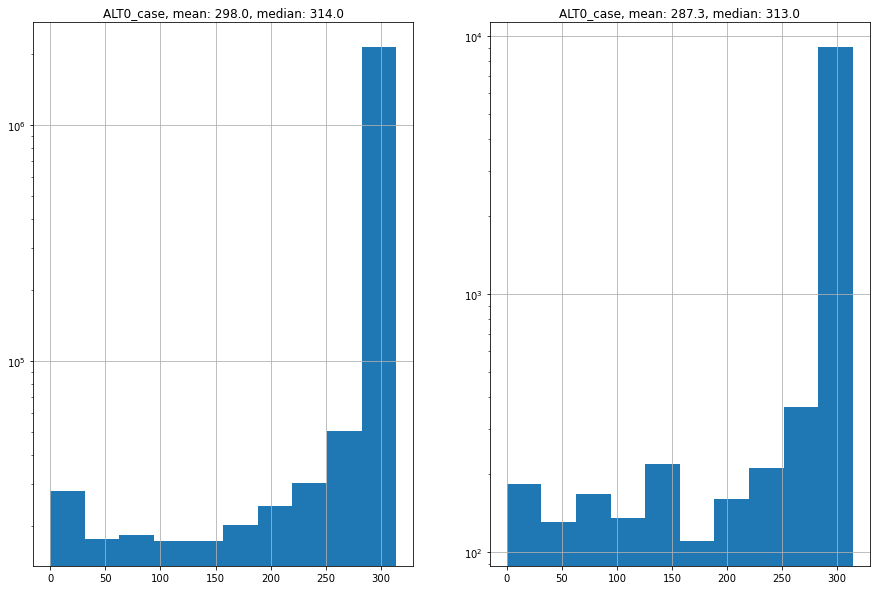

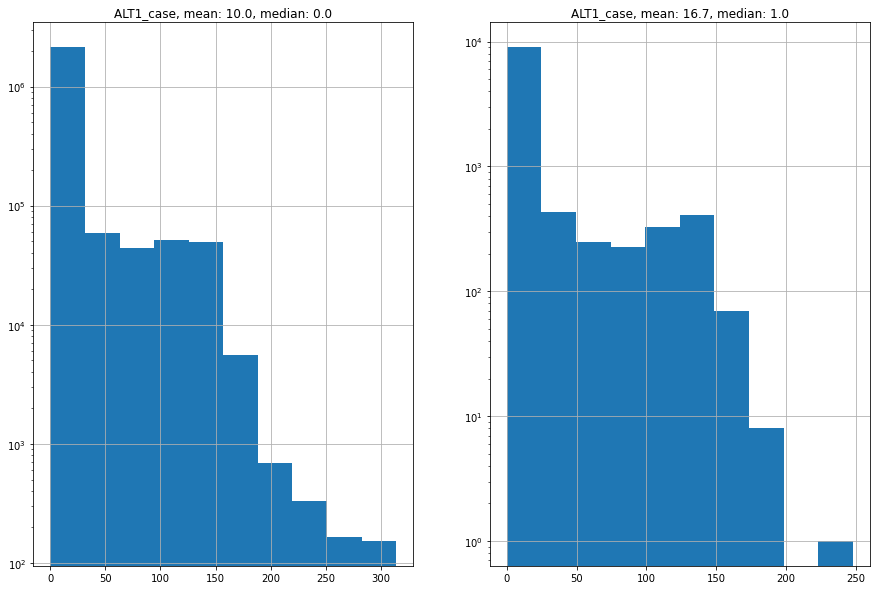

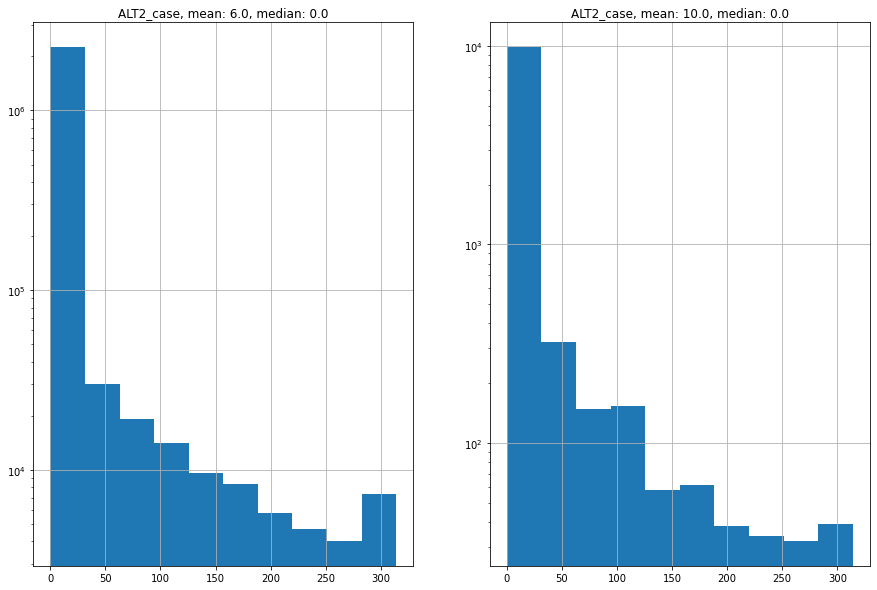

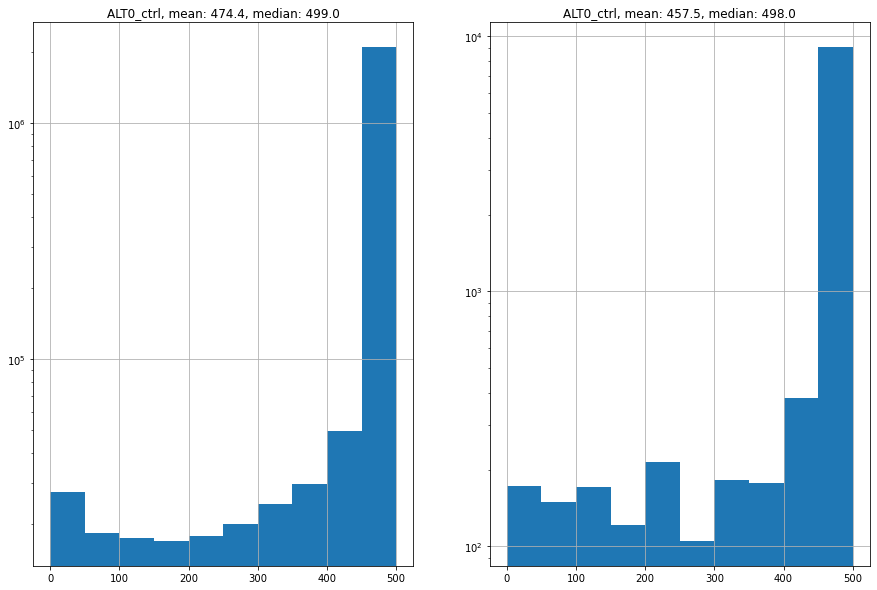

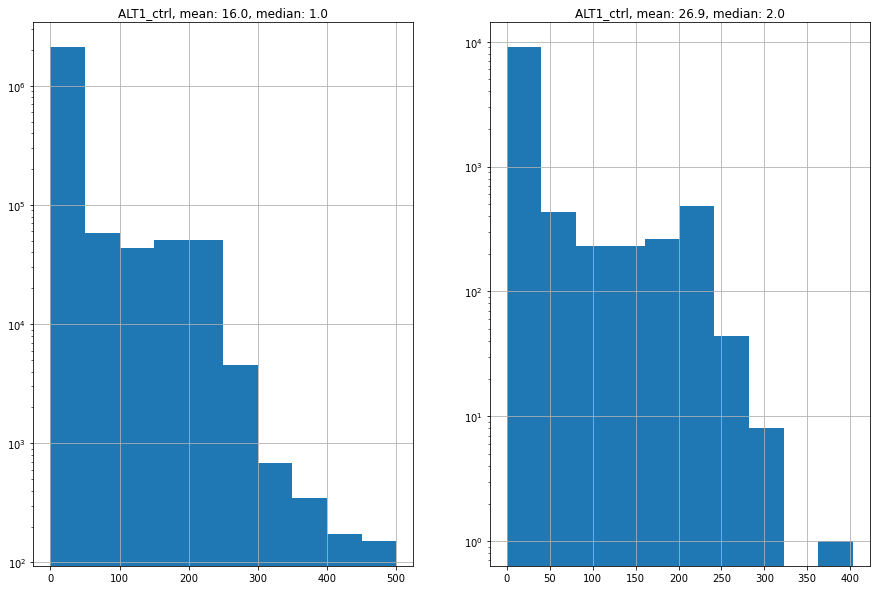

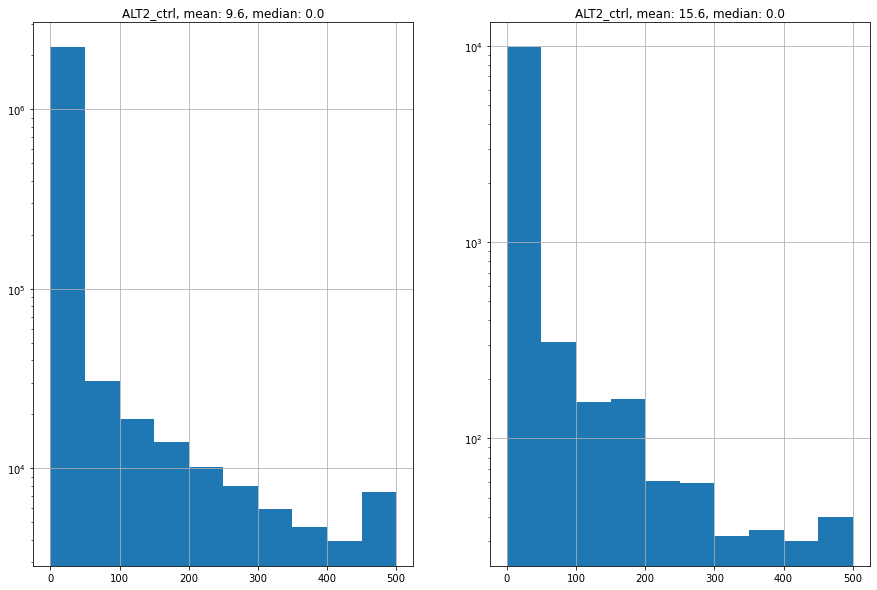

In [62]:
from matplotlib import pyplot as plt

for column in ['ALT0_case',	'ALT1_case',	'ALT2_case'	,'ALT0_ctrl'	,'ALT1_ctrl',	'ALT2_ctrl']:
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.title(f'{column}, mean: {pdf_case_control[column].mean().round(1)}, median: {pdf_case_control[column].median().round(1)}')
    pdf_case_control[column].hist(log=True)
    plt.subplot(1,2,2)
    plt.title(f'{column}, mean: {merge_on_RS[column].mean().round(1)}, median: {merge_on_RS[column].median().round(1)}')
    merge_on_RS[column].hist(log=True)